In [1]:
import numpy as np 
import pandas as pd


In [2]:
import pandas as pd
import numpy as np
import sys
import keras
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

Using TensorFlow backend.


1.1.5
1.19.5
3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]
0.24.2


In [3]:

df = pd.read_csv('UNSW_NB15_testing-set.csv')
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [4]:

qp = pd.read_csv('UNSW_NB15_training-set.csv')
qp

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


In [5]:

df = df.drop('id', 1) 
df.shape

(175341, 44)

In [6]:
df = df.drop('label', 1) 
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal


In [7]:
qp = qp.drop('id', 1)
qp = qp.drop('label', 1)
qp.shape

(82332, 43)

In [8]:
df.isnull().values.any()

False

In [9]:
qp.isnull().values.any()

False

In [10]:
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [11]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, 1)
    return df

In [12]:
combined_data = pd.concat([df,qp])
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,1,2,0,0,0,2,1,0,Normal
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,1,0,0,0,3,2,0,Normal
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal


In [13]:
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,1,2,0,0,0,2,1,0,Normal
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,1,0,0,0,3,2,0,Normal
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal


In [14]:
tmp = combined_data.pop('attack_cat')

In [15]:
combined_data = one_hot(combined_data,cols)

In [16]:
combined_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,...,0,0,0,0,0,0,0,0,0,0
1,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,...,0,0,0,0,0,0,0,0,0,0
2,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,...,0,0,0,0,0,0,0,0,0,0
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,...,1,0,0,0,0,0,0,0,0,0
4,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,...,0,0,0,0,0,0,0,0,0,0
82328,1.106101,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,...,0,0,0,0,0,0,0,0,0,0
82329,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0
82330,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [17]:
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() 
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [18]:
new_train_df = normalize(combined_data,combined_data.columns)
new_train_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82328,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82329,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82330,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
tmp

0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
          ...  
82327    Normal
82328    Normal
82329    Normal
82330    Normal
82331    Normal
Name: attack_cat, Length: 257673, dtype: object

In [20]:
new_train_df["Class"] = tmp
new_train_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,Class
0,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
4,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
82328,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
82329,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
82330,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


In [21]:
new_train_df.isnull().values.any()

False

In [22]:
y_train=new_train_df["Class"]
y_train

0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
          ...  
82327    Normal
82328    Normal
82329    Normal
82330    Normal
82331    Normal
Name: Class, Length: 257673, dtype: object

In [23]:
y_train.isnull().values.any()

False

In [24]:
combined_data_X = new_train_df.drop('Class', 1)
combined_data_X

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82328,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82329,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82330,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
oos_pred = []

In [26]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

In [27]:
kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
kfold.get_n_splits(combined_data_X,y_train)

2

In [28]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=64, border_mode="same",activation="relu",input_shape=(196, 1)))
model.add(MaxPooling1D(pool_length=(10)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape = (128, )))
model.add(MaxPooling1D(pool_length=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.6))
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

/root/anaconda3/envs/exp1/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=64, activation="relu", input_shape=(196, 1), padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/root/anaconda3/envs/exp1/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=10)`
  after removing the cwd from sys.path.
/root/anaconda3/envs/exp1/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=5)`
  


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [29]:
for layer in model.layers:
    print(layer.output_shape)

(None, 196, 64)
(None, 19, 64)
(None, 19, 64)
(None, 128)
(None, 128, 1)
(None, 25, 1)
(None, 25, 1)
(None, 256)
(None, 256)
(None, 10)
(None, 10)


In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 196, 64)           4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 64)            256       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 1)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 1)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 1)             4         
__________

In [31]:
for train_index, test_index in kfold.split(combined_data_X,y_train):
    train_X, test_X = combined_data_X.iloc[train_index], combined_data_X.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]
    
    print("train index:",train_index)
    print("test index:",test_index)
    print(train_y.value_counts())
    
    train_X_over,train_y_over= oversample.fit_resample(train_X, train_y)
    print(train_y_over.value_counts())
    
    x_columns_train = new_train_df.columns.drop('Class')
    x_train_array = train_X_over[x_columns_train].values
    x_train_1=np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))
    
    dummies = pd.get_dummies(train_y_over)
    outcomes = dummies.columns
    num_classes = len(outcomes)
    y_train_1 = dummies.values
    
    x_columns_test = new_train_df.columns.drop('Class')
    x_test_array = test_X[x_columns_test].values
    x_test_2=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))
    
    dummies_test = pd.get_dummies(test_y) 
    outcomes_test = dummies_test.columns
    num_classes = len(outcomes_test)
    y_test_2 = dummies_test.values
    
   
    model.fit(x_train_1, y_train_1,validation_data=(x_test_2,y_test_2), epochs=2)
    
    pred = model.predict(x_test_2)
    pred = np.argmax(pred,axis=1)
    y_eval = np.argmax(y_test_2,axis=1)
    score = metrics.accuracy_score(y_eval, pred)
    oos_pred.append(score)
    print("Validation score: {}".format(score))

train index: [     1      4      6 ... 257667 257669 257670]
test index: [     0      2      3 ... 257668 257671 257672]
Normal            46500
Generic           29435
Exploits          22262
Fuzzers           12123
DoS                8177
Reconnaissance     6994
Analysis           1339
Backdoor           1164
Shellcode           755
Worms                87
Name: Class, dtype: int64
Normal            46500
Worms             46500
Generic           29435
Exploits          22262
Fuzzers           12123
DoS                8177
Reconnaissance     6994
Analysis           1339
Backdoor           1164
Shellcode           755
Name: Class, dtype: int64
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 175249 samples, validate on 128837 samples
Epoch 1/2





175249/175249 [==============================] - 462s 3ms/step - loss: 0.6088 - acc: 0.7808 - val_loss: 0.6392 - val_acc: 0.7540
Epoch 2/2
175249/175249 [=============================

In [32]:
pred

array([3, 6, 6, ..., 9, 6, 6])

In [33]:
oos_pred

[0.7772534287510575, 0.7871091930826788]

In [34]:
test_y.value_counts()

Normal            46500
Generic           29435
Exploits          22262
Fuzzers           12123
DoS                8177
Reconnaissance     6994
Analysis           1339
Backdoor           1164
Shellcode           755
Worms                87
Name: Class, dtype: int64

In [35]:
dummies_test.columns

Index(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
      dtype='object')

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
confussion_matrix=confusion_matrix(y_eval, pred, labels=[0, 1, 2, 3, 4, 5,6, 7, 8, 9])

In [38]:
confussion_matrix

array([[    0,     0,     2,  1093,     1,     1,   242,     0,     0,
            0],
       [    0,     0,     7,  1070,     0,     0,     7,    72,     0,
            8],
       [    0,     0,   109,  7469,   119,    53,   158,   134,    24,
          111],
       [    0,     0,    96, 19771,   427,    26,   726,   437,    22,
          757],
       [    0,     0,    10,  1497,  4021,    19,  5917,   482,     9,
          168],
       [    0,     0,    51,   577,    42, 28644,    59,    27,     8,
           27],
       [    0,     0,     1,   416,  1476,     1, 43918,   519,     9,
          160],
       [    0,     0,     5,  1861,    53,    13,   240,  4778,     2,
           42],
       [    0,     0,     0,    60,    44,     0,    74,   438,    97,
           42],
       [    0,     0,     0,    11,     1,     0,     5,     0,     0,
           70]])

In [39]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

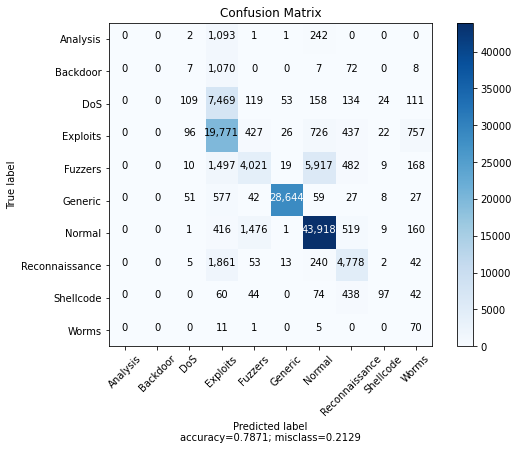

In [40]:
plot_confusion_matrix(cm           = confussion_matrix, 
                      normalize    = False,
                      target_names = ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic','Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
                      title        = "Confusion Matrix")

In [41]:
target_class=[]
target_class=["Analysis","Backdoor","DoS", "Exploits", "Fuzzers", "Generic","Normal","Reconnaissance", "Shellcode", "Worms"]

In [42]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [43]:
pred1 = model.predict(x_test_2)

/root/anaconda3/envs/exp1/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


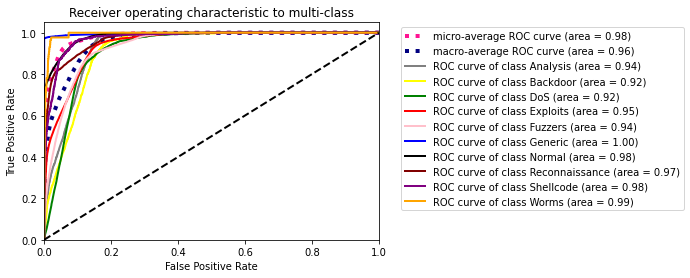

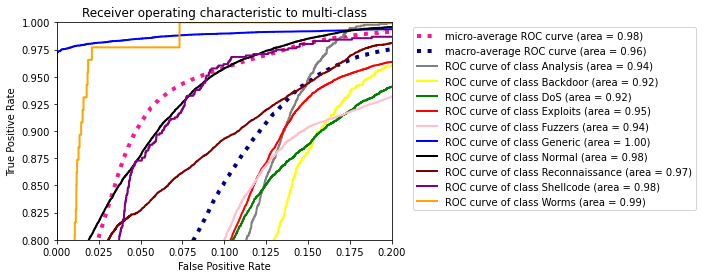

In [44]:

lw = 2


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_2[:, i], pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_2.ravel(), pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])


mean_tpr /= 10

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['grey', 'yellow', 'green','red','pink','blue','black','maroon','purple','orange'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#zoom in the plot
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['grey', 'yellow', 'green','red','pink','blue','black','maroon','purple','orange'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()